# Memory task machine learning
## Matt Oberhardt

### Initial setup

In [1]:
import synapseclient
from synapseclient import Project, Folder, File
import pandas as pd
import json
import pickle
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
import seaborn as sns
import os
from numpy import nan
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import ranksums
%load_ext autoreload
%autoreload 2
%matplotlib inline  


## set options ##

sns.set(style="darkgrid", color_codes=True, font_scale=1.5)

# so i can see all rows of dfs
pd.set_option('display.max_columns', 500)

# so that i can print as many lines as i want
np.set_printoptions(threshold='nan') 

## import my memorytools module ##

import memorytools as mt

In [2]:
# Load up the memory & demographic data:

# initialize environment:
synuser = os.environ['SYNAPSE_USER']
synpass = os.environ['SYNAPSE_PASS']
mt.loadSynapseRecordsFromScratch = False
syn, memory, memorysyn, filePaths, demographics, demosyn, data = mt.create_memory_environment(synuser, synpass)
data = mt.filter_data_for_popular_phones(data)

# pull out features from games:
fromFile = True#False
toSave = False#True
data = mt.add_memory_game_features_to_data(filePaths, data, fromFile = fromFile, toSave=toSave, outFileName='memory_data_with_features.p')

# add memory composite features:
data = mt.add_composite_features_to_data(data)

Welcome, Matthew Oberhardt!
(phones are now filtered for only the most popular ones)
memory features loaded from file: memory_data_with_features.p (input data was ignored)
Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds


### Machine learning setup

In [3]:
from sklearn import linear_model
import sklearn
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.tree
import sklearn.ensemble
import numpy as np
from sklearn.utils.validation import check_consistent_length, _num_samples
import sklearn.preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# load feature categories
fcats = mt.define_feature_categories()


Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds


### Run random forest after age-matching and sample balancing, with different feature sets

In [ ]:
# 
! rewrite code so it can handle case with no age & no hasParkinsons in the actual ML X matrix.. (the latter when hasParkinsons should be not what's predicted')

Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds
Features converted to numbers:

[]
dropped 299 rows to remove all nas from data
na rows have been dropped (if there were any)
RanksumsResult(statistic=-1.8430869854477361, pvalue=0.065316311209922928)
RanksumsResult(statistic=-1.3514370185056759, pvalue=0.17655548223886841)
training accuracy: 1.0
test accuracy: 0.763888888889
num actual positives = 600
num actual negatives = 600
random accuracy would be 0.5


feature importances:
game_numGames            0.000271
played_game4             0.000368
9_successful             0.001919
9_numunsuccesses         0.002637
game_numFails            0.004756
9_numsuccesses           0.007333
9_gamescore              0.008943
16_successful            0.010638
16_numunsuccesses        0.010878
16_gamescore             0.031940
game_score               0.031955
16_numsuccesses          0.031961
16_latency               0.054343
16_firstdist             0.058270
9_latency                0.06078

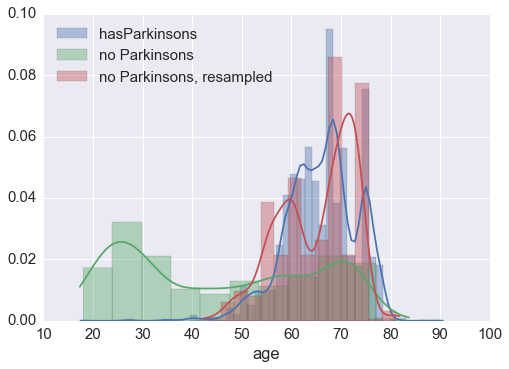

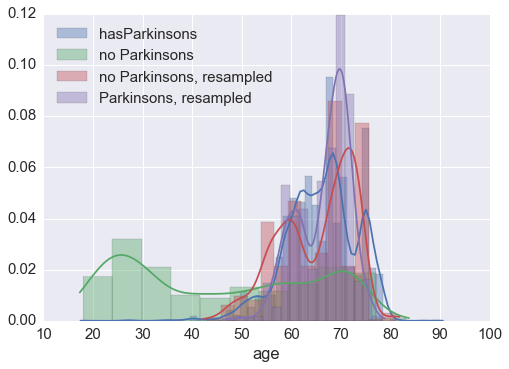

In [4]:

fcats = mt.define_feature_categories()
features = fcats['game'] + ['hasParkinsons'] + ['age']
#features.remove('medTimepoint')
outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, labelcol='hasParkinsons', toPlot=True)


In [6]:
# visualize this new dataset (resampled):

##featurestoPlot = ["age", "game_score", '9_gamescore', '9_latency', '9_meanDt', '9_firstdist', '9_meandist']
##features_df = data[["game_score",'16_gamescore','hasParkinsons']]
#fplot = features_df[['16_meanDt','16_latency', '16_firstdist', '16_meandist', 'hasParkinsons']]
#plotfeatures = ['16_meanDt','16_latency', '16_firstdist', '16_meandist']
##fplot = fplot.dropna()
#g = sns.pairplot(fplot, x_vars=plotfeatures,y_vars=plotfeatures,hue="hasParkinsons", palette="Set2", diag_kind="kde", markers="o")#, size=2.5)


Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds
Features converted to numbers:

['gender', 'education']
dropped 303 rows to remove all nas from data
na rows have been dropped (if there were any)


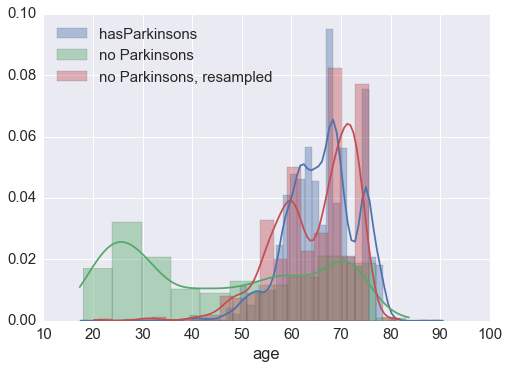

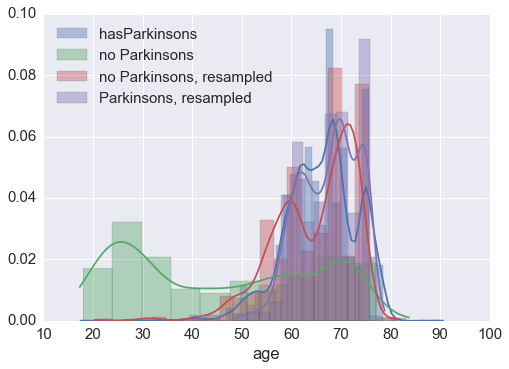

RanksumsResult(statistic=-2.5304379735474409, pvalue=0.01139202251317715)
RanksumsResult(statistic=-5.6734698798336769, pvalue=1.3993371423112521e-08)
training accuracy: 1.0
test accuracy: 0.830555555556
num actual positives = 600
num actual negatives = 600
random accuracy would be 0.5


feature importances:
game_numGames            0.000000
played_game4             0.000410
9_numunsuccesses         0.002519
9_successful             0.002610
game_numFails            0.003950
9_numsuccesses           0.006617
9_gamescore              0.007085
16_successful            0.009158
16_numunsuccesses        0.009344
16_numsuccesses          0.022645
16_gamescore             0.025321
game_score               0.026465
gender                   0.028186
education                0.031770
16_firstdist             0.046391
9_firstdist              0.048771
16_latency               0.055878
16_meansuccessfuldist    0.057136
16_meandist              0.058027
9_meansuccessfuldist     0.059634
9_meandist

In [8]:
# Run ML with 

fcats = mt.define_feature_categories()
features = fcats['game'] + fcats['demographic'] + ['hasParkinsons'] #+ fcats['output']
#features.remove('medTimepoint')
outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, toPlot=True)


In [ ]:
# To Do:

# package the resampling code into a function

# add age back in as variable now, and rerun random forest
# try logistic regression, with l1 (lasso) (minimize # features)

# do pca of outputs, and see if we can be more predictive
# split data by person and check on drugs vs not on drugs (what is predictive)
# time series analysis of indiv. patients, looking at the yes and no data?
# symptom variance individual patients plot?
# run rand forest with all in-game features & sample balancing but not correction for age

